# 4 Preprocessing and Training Data Development 

## Table of Contents:

* [4.1 Introduction](#4.1_Introduction)
* [4.2 Import Packages](#4.2_Import_Packages)
* [4.3 Load the Data](#4.3_Load_the_Data)
* [4.4 Featurizing (one last time)](#4.4_Featurizing)
* [4.5 Train/Test Split](#4.5_Train_Test_Split)
* [4.6 Scaling the Data](#4.6_Scaling_the_Data)
* [4.7 Exporting the Data](#4.7_Exporting_the_Data)
* [4.8 Summary and Next Steps](#4.8_Summary_and_Next_Steps)

## 4.1 Introduction<a id='4.1_Introduction'></a>

In our Exploratory Data Analysis notebook, we imputed our missing Transdermal Alcohol Content (TAC) data with two different methods, resulting in two datasets of 13 dataframes each:
1. In the first method, we interpolated the raw data with a polynomial fitting on the 3rd, 5th, 7th, and 9th orders.
2. In the second method, we smoothed the TAC data with a triangular moving average of window size 3 (1.5 hours, as each TAC datapoint is measured per 30 minutes), followed by interpolation with a 3rd order polynomial fitting. We also used a triangular moving average to make a smoothed set of the accelerometer data.

After bifurcating our data (resulting in a total of 26 dataframes), we featurized the x, y, and z-axes of each df to get 156 additional features. All dataframes were exported as CSV files. 

We investigated relationships between features using PCA, correlation heatmaps, scatterplots, histograms, and boxplots. There does not appear to be a clear visual distinction between the characteristics of the participant whent they are legally drunk (TAC >= 0.08) versus when they are legally sober (TAC < 0.08). However, from a visual assessment of the boxplots, there appears to be less variation in the features for the participant when they are sober compared to when they are intoxicated. This investigation indicates we may want to generate a few more features (such as the standard deviation of our existing features).

In this notebook, we will do the following:
1. __Featurize:__ We will featurize our datasets one last time by calculating the standard deviation of each feature, doubling our features from 156 to 312. 
2. __Train/Test Split:__ For both our raw/interpolated data and our TMA-smoothed data, we will conduct a 70/30 train/test split. We should take note that there are many more instances of non-intoxicated samples than intoxicated samples. It may be beneficial to account for these differences by removing some non-intoxicated instances to achieve closer to a 50/50 split.
3. __Scaling the Data:__ Since our features are all on different scales (different magnitudes), we will scale our training data. Then, using our scaler than was trained on the training data, we will apply that scaler to the test data (it is imperative that we do not fit our scaler to the test data, as the test data should not be looked at as much as possible in proper machine learning modeling).

## 4.2 Import Packages<a id='4.2_Import_Packages'></a>

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
import timeit
import time
import random

import multiprocessing as mp
from multiprocessing import Process, Queue, Lock, Pool
from multiprocessing.pool import ThreadPool
import defs # defs.py, has our featurizing fxns that we'll call during multiprocessing 

## 4.3 Load the Data<a id='4.3_Load_the_Data'></a>

In [2]:
# change directories to where the processed data is located.

path = 'D:\Documents\Springboard\Capstone 2 - heavy drinking project\data'
os.chdir(path)
os.getcwd()

'D:\\Documents\\Springboard\\Capstone 2 - heavy drinking project\\data'

In [3]:
#The raw data is 25.7 GB and the tma data is 27.3 GB. 
# Raw/interpolated data: #This section should not be uncommented unless your system has > 50 GB RAM

# pid1_featurized = pd.read_csv('pid1_featurized.csv')
# pid2_featurized = pd.read_csv('pid2_featurized.csv')
# pid3_featurized = pd.read_csv('pid3_featurized.csv')
# pid4_featurized = pd.read_csv('pid4_featurized.csv')
# pid5_featurized = pd.read_csv('pid5_featurized.csv')
# pid6_featurized = pd.read_csv('pid6_featurized.csv')
# pid7_featurized = pd.read_csv('pid7_featurized.csv')
# pid8_featurized = pd.read_csv('pid8_featurized.csv')
# pid9_featurized = pd.read_csv('pid9_featurized.csv')
# pid10_featurized = pd.read_csv('pid10_featurized.csv')
# pid11_featurized = pd.read_csv('pid11_featurized.csv')
# pid12_featurized = pd.read_csv('pid12_featurized.csv')
# pid13_featurized = pd.read_csv('pid13_featurized.csv')


In [4]:
# TMA-smoothed data: #This section should not be uncommented unless your system has > 50 GB RAM

# pid1_tma_featurized = pd.read_csv('pid1_tma_featurized.csv')
# pid2_tma_featurized = pd.read_csv('pid2_tma_featurized.csv')
# pid3_tma_featurized = pd.read_csv('pid3_tma_featurized.csv')
# pid4_tma_featurized = pd.read_csv('pid4_tma_featurized.csv')
# pid5_tma_featurized = pd.read_csv('pid5_tma_featurized.csv')
# pid6_tma_featurized = pd.read_csv('pid6_tma_featurized.csv')
# pid7_tma_featurized = pd.read_csv('pid7_tma_featurized.csv')
# pid8_tma_featurized = pd.read_csv('pid8_tma_featurized.csv')
# pid9_tma_featurized = pd.read_csv('pid9_tma_featurized.csv')
# pid10_tma_featurized = pd.read_csv('pid10_tma_featurized.csv')
# pid11_tma_featurized = pd.read_csv('pid11_tma_featurized.csv')
# pid12_tma_featurized = pd.read_csv('pid12_tma_featurized.csv')
# pid13_tma_featurized = pd.read_csv('pid13_tma_featurized.csv')

Here we run into a conundrum. My raw/interpolated dataset is 25.7 GB and my TMA-smoothed dataset is 27.3 GB, but my system only has 16 GB RAM. I am unable to fully load either set in its entirety at once. 

As an alternative approach, we can load each individual dataframe, run our featurization (i.e. calculating the standard deviation of each feature), and keep only a fraction of each df to use in our train/test split. A possible way to approach this is to select every 100th row, and drop the rest, since we do not need such granularity. This smaller df could then be written to a csv file, letting us work with much smaller data. The Multiprocessing python package would be useful in this step.

In [5]:
#put everything in a list

df_names_list = ['pid1_featurized.csv', 'pid2_featurized.csv', 'pid3_featurized.csv', 'pid4_featurized.csv', \
                'pid5_featurized.csv', 'pid6_featurized.csv', 'pid7_featurized.csv', 'pid8_featurized.csv', \
                'pid9_featurized.csv', 'pid10_featurized.csv', 'pid11_featurized.csv', 'pid12_featurized.csv', \
                'pid13_featurized.csv', 'pid1_tma_featurized.csv', 'pid2_tma_featurized.csv', 'pid3_tma_featurized.csv', \
                'pid4_tma_featurized.csv', 'pid5_tma_featurized.csv', 'pid6_tma_featurized.csv', 'pid7_tma_featurized.csv', \
                'pid8_tma_featurized.csv', 'pid9_tma_featurized.csv', 'pid10_tma_featurized.csv', \
                'pid11_tma_featurized.csv', 'pid12_tma_featurized.csv', 'pid13_tma_featurized.csv']

len(df_names_list)

26

## 4.4 Featurizing (one last time)<a id='4.4_Featurizing'></a>

In our Exploratory Data Analysis notebook, we saw that there appears to be less variation in the features for the participant when they are sober compared to when they are intoxicated. This investigation indicates we may want to generate a few more features, such as the standard deviation of our existing features.

We will featurize our datasets one last time by calculating the standard deviation of each feature, doubling our features from 156 to 306 (it results in 306 features instead of 312 due to duplicates such as [x,y,z]_[jerk,snap]_std. 

Fortunately, all of our data is quantitative and not categorical, so one-hot encoding is not needed.

In [6]:
def featurize_std_df(df_name):
    """Takes the name of a csv file, reads it into a pandas dataframe, and sets the "time" column as the index.
    Calculates the standard deviation on all of the features in "col_list", over a 10-second rolling window."""
    
    start = time.time()
    
    df = pd.read_csv(df_name)
    df.time = pd.to_datetime(df.time)
    df = df.set_index('time')
    
    #Note: x, y, z, and _jerk and _snap have been removed to not result in redundant _std features.
    col_list = ['x_mean', \
                 'x_std', \
                 'x_var', \
                 'x_median', \
                 'x_max_raw', \
                 'x_min_raw', \
                 'x_max_abs', \
                 'x_min_abs', \
                 'x_skew', \
                 'x_kurtosis', \
                 'x_zcr', \
                 'x_gait_stretch', \
                 'x_steps', \
                 'x_step_time', \
                 'x_rms', \
                 'x_jerk_mean', \
                 'x_jerk_std', \
                 'x_jerk_var', \
                 'x_jerk_median', \
                 'x_jerk_max_raw', \
                 'x_jerk_min_raw', \
                 'x_jerk_max_abs', \
                 'x_jerk_min_abs', \
                 'x_jerk_skew', \
                 'x_jerk_kurtosis', \
                 'x_jerk_zcr', \
                 'x_jerk_gait_stretch', \
                 'x_jerk_steps', \
                 'x_jerk_step_time', \
                 'x_jerk_rms', \
                 'x_snap_mean', \
                 'x_snap_std', \
                 'x_snap_var', \
                 'x_snap_median', \
                 'x_snap_max_raw', \
                 'x_snap_min_raw', \
                 'x_snap_max_abs', \
                 'x_snap_min_abs', \
                 'x_snap_skew',\
                 'x_snap_kurtosis', \
                 'x_snap_zcr', \
                 'x_snap_gait_stretch', \
                 'x_snap_steps', \
                 'x_snap_step_time', \
                 'x_snap_rms', \
                 'y_mean', \
                 'y_std', \
                 'y_var', \
                 'y_median', \
                 'y_max_raw', \
                 'y_min_raw', \
                 'y_max_abs', \
                 'y_min_abs', \
                 'y_skew', \
                 'y_kurtosis', \
                 'y_zcr', \
                 'y_gait_stretch', \
                 'y_steps', \
                 'y_step_time', \
                 'y_rms', \
                 'y_jerk_mean', \
                 'y_jerk_std', \
                 'y_jerk_var', \
                 'y_jerk_median', \
                 'y_jerk_max_raw', \
                 'y_jerk_min_raw', \
                 'y_jerk_max_abs', \
                 'y_jerk_min_abs', \
                 'y_jerk_skew', \
                 'y_jerk_kurtosis', \
                 'y_jerk_zcr', \
                 'y_jerk_gait_stretch', \
                 'y_jerk_steps', \
                 'y_jerk_step_time', \
                 'y_jerk_rms', \
                 'y_snap_mean', \
                 'y_snap_std', \
                 'y_snap_var', \
                 'y_snap_median', \
                 'y_snap_max_raw', \
                 'y_snap_min_raw', \
                 'y_snap_max_abs', \
                 'y_snap_min_abs', \
                 'y_snap_skew', \
                 'y_snap_kurtosis', \
                 'y_snap_zcr', \
                 'y_snap_gait_stretch', \
                 'y_snap_steps', \
                 'y_snap_step_time', \
                 'y_snap_rms', \
                 'z_mean', \
                 'z_std', \
                 'z_var', \
                 'z_median', \
                 'z_max_raw', \
                 'z_min_raw', \
                 'z_max_abs', \
                 'z_min_abs', \
                 'z_skew', \
                 'z_kurtosis', \
                 'z_zcr', \
                 'z_gait_stretch', \
                 'z_steps', \
                 'z_step_time', \
                 'z_rms', \
                 'z_jerk_mean', \
                 'z_jerk_std', \
                 'z_jerk_var', \
                 'z_jerk_median', \
                 'z_jerk_max_raw', \
                 'z_jerk_min_raw', \
                 'z_jerk_max_abs', \
                 'z_jerk_min_abs', \
                 'z_jerk_skew', \
                 'z_jerk_kurtosis', \
                 'z_jerk_zcr', \
                 'z_jerk_gait_stretch', \
                 'z_jerk_steps', \
                 'z_jerk_step_time', \
                 'z_jerk_rms', \
                 'z_snap_mean', \
                 'z_snap_std', \
                 'z_snap_var', \
                 'z_snap_median', \
                 'z_snap_max_raw', \
                 'z_snap_min_raw', \
                 'z_snap_max_abs', \
                 'z_snap_min_abs', \
                 'z_snap_skew', \
                 'z_snap_kurtosis', \
                 'z_snap_zcr', \
                 'z_snap_gait_stretch', \
                 'z_snap_steps', \
                 'z_snap_step_time', \
                 'z_snap_rms', \
                 'xyz_ara', \
                 'xyz_jerk_ara', \
                 'xyz_snap_ara', \
                 'dx_dy', \
                 'dx_dz', \
                 'dy_dx', \
                 'dy_dz', \
                 'dz_dx', \
                 'dz_dy', \
                 'ddx_ddy', \
                 'ddx_ddz', \
                 'ddy_ddx', \
                 'ddy_ddz', \
                 'ddz_ddx', \
                 'ddz_ddy']
    
    for col in col_list:
        df[col+'_std'] = df[col].rolling('10s').std()

    df = df.iloc[::100, :]
    df.to_csv(df_name[:-4]+'_std.csv') #removes the last 4 characters '.csv' and appends '_std'
    print(df_name, 'Time:', time.time() - start)

In [7]:
start_time = time.time()

if __name__ ==  '__main__': 
    num_processors = 9 #Note, we can do up to 10
    p=Pool(processes = num_processors)
    output = p.map(defs.featurize_std_df,[i for i in df_names_list])

print('Total Time:', time.time() - start_time)

Total Time: 1142.0639271736145


Our 26 dataframes were successfully resampled to keep only every 100 rows, and exported as csv files. Our total file size is now only 1.14 GB instead of 53 GB, a big improvement in terms of ease-of-use.

## 4.5 Train/Test Split<a id='4.5_Train_Test_Split'></a>

Prior to our train/test split, we need to load our resampled df's, and make sure our data is balanced. We know from our Data Wrangling notebook that there are far more instances of TAC >= 0.08 than there are of TAC < 0.08. We also know that certain participants have far more rows than others (e.g. pid3 has around 6 times more rows than pid8). 

One approach we can use to balance our data is to find the total number of drunk/sober instances for each participant. Using the smallest set (for example, the number of pid8 drunk rows), we randomly sample from all other sets so that every participant is equally represented in the final dataset, and there is a 50/50 split of intoxicated/non-intoxicated rows in our dataset.

After we balance our data, for both our raw/interpolated data and our TMA-smoothed data, we will conduct a 70/30 train/test split.

In [8]:
# let's build a new list of df names, using our new df's (with '_std' added in each filename)

df_std_list = [] #makes empty list
for name in df_names_list:
    df_std_list.append(name[:-4]+'_std.csv')
    
df_std_list

['pid1_featurized_std.csv',
 'pid2_featurized_std.csv',
 'pid3_featurized_std.csv',
 'pid4_featurized_std.csv',
 'pid5_featurized_std.csv',
 'pid6_featurized_std.csv',
 'pid7_featurized_std.csv',
 'pid8_featurized_std.csv',
 'pid9_featurized_std.csv',
 'pid10_featurized_std.csv',
 'pid11_featurized_std.csv',
 'pid12_featurized_std.csv',
 'pid13_featurized_std.csv',
 'pid1_tma_featurized_std.csv',
 'pid2_tma_featurized_std.csv',
 'pid3_tma_featurized_std.csv',
 'pid4_tma_featurized_std.csv',
 'pid5_tma_featurized_std.csv',
 'pid6_tma_featurized_std.csv',
 'pid7_tma_featurized_std.csv',
 'pid8_tma_featurized_std.csv',
 'pid9_tma_featurized_std.csv',
 'pid10_tma_featurized_std.csv',
 'pid11_tma_featurized_std.csv',
 'pid12_tma_featurized_std.csv',
 'pid13_tma_featurized_std.csv']

In [9]:
#Load all the df's
def load_and_set_datetime_index(df_name):
    df = pd.read_csv(df_name)
    df.time = pd.to_datetime(df.time)
    df = df.set_index('time')
    return df

pid1 = load_and_set_datetime_index(df_std_list[0])
pid2 = load_and_set_datetime_index(df_std_list[1])
pid3 = load_and_set_datetime_index(df_std_list[2])
pid4 = load_and_set_datetime_index(df_std_list[3])
pid5 = load_and_set_datetime_index(df_std_list[4])
pid6 = load_and_set_datetime_index(df_std_list[5])
pid7 = load_and_set_datetime_index(df_std_list[6])
pid8 = load_and_set_datetime_index(df_std_list[7])
pid9 = load_and_set_datetime_index(df_std_list[8])
pid10 = load_and_set_datetime_index(df_std_list[9])
pid11 = load_and_set_datetime_index(df_std_list[10])
pid12 = load_and_set_datetime_index(df_std_list[11])
pid13 = load_and_set_datetime_index(df_std_list[12])
pid1_tma = load_and_set_datetime_index(df_std_list[13])
pid2_tma = load_and_set_datetime_index(df_std_list[14])
pid3_tma = load_and_set_datetime_index(df_std_list[15])
pid4_tma = load_and_set_datetime_index(df_std_list[16])
pid5_tma = load_and_set_datetime_index(df_std_list[17])
pid6_tma = load_and_set_datetime_index(df_std_list[18])
pid7_tma = load_and_set_datetime_index(df_std_list[19])
pid8_tma = load_and_set_datetime_index(df_std_list[20])
pid9_tma = load_and_set_datetime_index(df_std_list[21])
pid10_tma = load_and_set_datetime_index(df_std_list[22])
pid11_tma = load_and_set_datetime_index(df_std_list[23])
pid12_tma = load_and_set_datetime_index(df_std_list[24])
pid13_tma = load_and_set_datetime_index(df_std_list[25])


In [10]:
pid_raw_list = [pid1, pid2, pid3, pid4, pid5, pid6, pid7, pid8, pid9, pid10, pid11, pid12, pid13]
pid_tma_list = [pid1_tma, pid2_tma, pid3_tma, pid4_tma, pid5_tma, pid6_tma, \
                pid7_tma, pid8_tma, pid9_tma, pid10_tma, pid11_tma, pid12_tma, pid13_tma]

In [11]:
# Check to see the number of instances above or below 8% TAC for each individual.
TAC_instances = {}

for i in range(13):
    TAC_instances[df_names_list[i]] = [(pid_raw_list[i].order_3 >=0.08).sum(),
                                      (pid_raw_list[i].order_3 <0.08).sum(),
                                      (pid_raw_list[i].order_3.count())]

above_8 = 0
below_8 = 0

for i in range(13):
    key = df_names_list[i]
    above_8 += TAC_instances[key][0]
    below_8 += TAC_instances[key][1]

print("Number of instances >= 8% TAC:", above_8)
print("Number of instances < 8% TAC:", below_8)
print('There are', str(below_8 - above_8), 'more sober rows than intoxicated rows.')
print()

TAC_instances

Number of instances >= 8% TAC: 34337
Number of instances < 8% TAC: 79454
There are 45117 more sober rows than intoxicated rows.



{'pid1_featurized.csv': [7203, 5055, 12258],
 'pid2_featurized.csv': [1291, 3184, 4475],
 'pid3_featurized.csv': [4465, 12394, 16859],
 'pid4_featurized.csv': [1403, 4511, 5914],
 'pid5_featurized.csv': [809, 10309, 11118],
 'pid6_featurized.csv': [1424, 9747, 11171],
 'pid7_featurized.csv': [2945, 8833, 11778],
 'pid8_featurized.csv': [2385, 691, 3076],
 'pid9_featurized.csv': [2772, 414, 3186],
 'pid10_featurized.csv': [2437, 3877, 6314],
 'pid11_featurized.csv': [1468, 12983, 14451],
 'pid12_featurized.csv': [1064, 5497, 6561],
 'pid13_featurized.csv': [4671, 1959, 6630]}

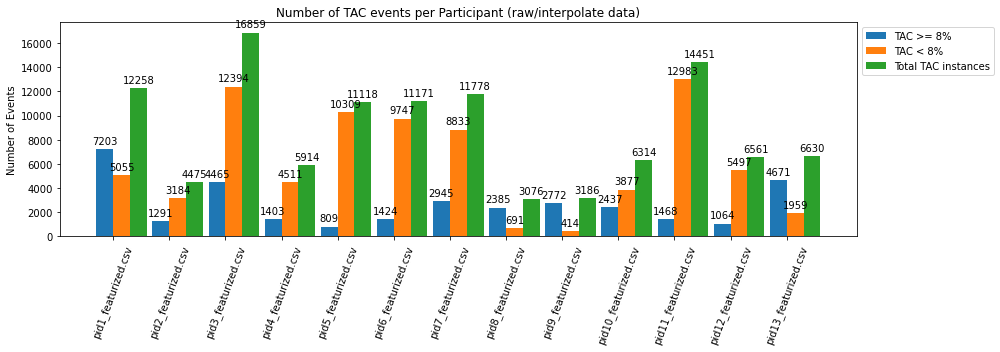

In [12]:
# Here we graph bar plots of the data.
# Use as reference: 
# https://matplotlib.org/3.3.2/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py

# make empty lists
labels = df_names_list[0:13]
above_8 = []
below_8 = []
total =[]

# populate those lists from pid_TAC_instances dictionary
for i in range(13):
    key = df_names_list[i]
    above_8.append(TAC_instances[key][0])
    below_8.append(TAC_instances[key][1])
    total.append(TAC_instances[key][2])

x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots(figsize=(14,5))
rects1 = ax.bar(x - width/2, above_8, width, label='TAC >= 8%')
rects2 = ax.bar(x + width/2, below_8, width, label='TAC < 8%')
rects3 = ax.bar(x + 1.5*width, total, width, label='Total TAC instances')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of Events')
ax.set_title('Number of TAC events per Participant (raw/interpolate data)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.xticks(rotation=70)

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()

plt.show()

Number of instances >= 8% TAC: 34184
Number of instances < 8% TAC: 79607
There are 45423 more sober rows than intoxicated rows.



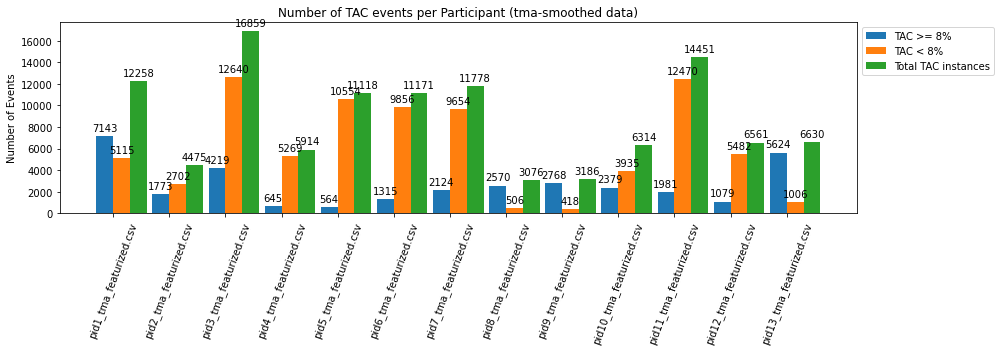

In [13]:
#Now we do the same for the tma-smoothed data

TAC_instances = {}

for i in range(13):
    TAC_instances[df_names_list[i+13]] = [(pid_tma_list[i].tma >=0.08).sum(),
                                      (pid_tma_list[i].tma <0.08).sum(),
                                      (pid_tma_list[i].tma.count())]

above_8 = 0
below_8 = 0

for i in range(13):
    key = df_names_list[i+13]
    above_8 += TAC_instances[key][0]
    below_8 += TAC_instances[key][1]

print("Number of instances >= 8% TAC:", above_8)
print("Number of instances < 8% TAC:", below_8)
print('There are', str(below_8 - above_8), 'more sober rows than intoxicated rows.')
print()

TAC_instances

#make a bar graph

labels = df_names_list[13:26]
above_8 = []
below_8 = []
total =[]

for i in range(13):
    key = df_names_list[i+13]
    above_8.append(TAC_instances[key][0])
    below_8.append(TAC_instances[key][1])
    total.append(TAC_instances[key][2])

x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots(figsize=(14,5))
rects1 = ax.bar(x - width/2, above_8, width, label='TAC >= 8%')
rects2 = ax.bar(x + width/2, below_8, width, label='TAC < 8%')
rects3 = ax.bar(x + 1.5*width, total, width, label='Total TAC instances')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of Events')
ax.set_title('Number of TAC events per Participant (tma-smoothed data)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.xticks(rotation=70)

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()

plt.show()

Here we can see that some participant had more sober instances than drunk instances, as previously stated, while others have the opposite. The smallest number we see is 414 rows of TAC < 8% for pid9 (raw/interpolated data) and 418 rows of TAC < 8% for pid9 (tma-smoothed). We can use n=400 number as the number of rows we randomly select from each participant/class combination.

The final result would be a dataset that has equal representation of each participant and a 50/50 split of each binary class.

In [14]:
#Use the pandas df.sample() function to sample 400 rows from each df

n = 400

df_raw_above_8 = pid1[(pid1.order_3 > 0.08) & (pid1.order_5 > 0.08) & (pid1.order_7 > 0.08) & \
                      (pid1.order_9 > 0.08)].sample(n, random_state=1)
df_raw_below_8 = pid1[(pid1.order_3 < 0.08) & (pid1.order_5 < 0.08) & (pid1.order_7 < 0.08) & \
                      (pid1.order_9 < 0.08)].sample(n, random_state=1)

for i in range(12):    #use only 12 instead 13 because we already did the 1st one
    df = pid_raw_list[i+1]
    df_raw_above_8 = df_raw_above_8.append(df[(df.order_3 > 0.08) & (df.order_5 > 0.08) & \
                                              (df.order_7 > 0.08) & (df.order_9 > 0.08)].sample(n, random_state=1))
    df_raw_below_8 = df_raw_below_8.append(df[(df.order_3 < 0.08) & (df.order_5 < 0.08) & \
                                              (df.order_7 < 0.08) & (df.order_9 < 0.08)].sample(n, random_state=1))

In [15]:
#Since we selected 400 rows for each class from all 13 participants, we expect 5200 rows total.
print(df_raw_above_8.shape)
print(df_raw_below_8.shape)

#as expected, we have 5200 rows for each class.

(5200, 313)
(5200, 313)


In [16]:
#We repeat the earlier steps but for the tma-smoothed dataset

n = 400

df_tma_above_8 = pid1_tma[(pid1_tma.tma > 0.08)].sample(n, random_state=1)
df_tma_below_8 = pid1_tma[(pid1_tma.tma < 0.08)].sample(n, random_state=1)

for i in range(12):    #use only 12 instead 13 because we already did the 1st one
    df = pid_tma_list[i+1]
    df_tma_above_8 = df_tma_above_8.append(df[(df.tma > 0.08)].sample(n, random_state=1))
    df_tma_below_8 = df_tma_below_8.append(df[(df.tma < 0.08)].sample(n, random_state=1))

#Check for 5200 rows
print(df_tma_above_8.shape)
print(df_tma_below_8.shape)

(5200, 310)
(5200, 310)


In [17]:
#Now let's append df_raw_above_8 & df_raw_below_8 together

df_raw = df_raw_above_8.append(df_raw_below_8)
print(len(df_raw))

#simiarly append df_tma_above_8 & df_tma_below_8 together

df_tma = df_tma_above_8.append(df_tma_below_8)
print(len(df_tma))


10400
10400


We are almost ready for the train/test split. But before we do, let's make sure our data is clean and remove any columns full of NaNs, which may have cropped up while we featurized our df's earlier in this notebook.

In [18]:
#let's convert any infinite values to NaN values
df_raw = df_raw.replace([np.inf, -np.inf], np.nan)
df_raw.isna().sum()
#looking at the output, there is clearly some NaN values in the ddz_ddy_std section.

x                0
y                0
z                0
order_3          0
order_5          0
              ... 
ddx_ddz_std     87
ddy_ddx_std      2
ddy_ddz_std     87
ddz_ddx_std      2
ddz_ddy_std    229
Length: 313, dtype: int64

In [19]:
df_raw.isna().sum()[df_raw.isna().sum()>100]

#Here we can see the columns with at least 100 NaNs

x_step_time             131
y_skew                  662
y_step_time             397
y_jerk_step_time        304
y_snap_step_time        277
z_step_time             320
z_jerk_skew             171
z_jerk_step_time        258
z_snap_skew             159
z_snap_step_time        216
dx_dy                   478
dx_dz                   435
dy_dx                   118
dy_dz                   435
dz_dx                   118
dz_dy                   478
ddx_ddy                 359
ddx_ddz                 321
ddy_ddz                 321
ddz_ddy                 359
y_skew_std              658
y_step_time_std         265
y_jerk_step_time_std    219
y_snap_step_time_std    207
z_step_time_std         219
z_jerk_skew_std         121
z_jerk_step_time_std    186
z_snap_skew_std         111
z_snap_step_time_std    148
dx_dy_std               229
dz_dy_std               229
ddx_ddy_std             229
ddz_ddy_std             229
dtype: int64

In [20]:
#find all the columns that have >100 NaN values. 
columns_to_drop = df_raw.isna().sum()[df_raw.isna().sum()>100].keys()
print('There are', len(columns_to_drop),'columns with >100 NaN values')
print()
print(columns_to_drop)

There are 33 columns with >100 NaN values

Index(['x_step_time', 'y_skew', 'y_step_time', 'y_jerk_step_time',
       'y_snap_step_time', 'z_step_time', 'z_jerk_skew', 'z_jerk_step_time',
       'z_snap_skew', 'z_snap_step_time', 'dx_dy', 'dx_dz', 'dy_dx', 'dy_dz',
       'dz_dx', 'dz_dy', 'ddx_ddy', 'ddx_ddz', 'ddy_ddz', 'ddz_ddy',
       'y_skew_std', 'y_step_time_std', 'y_jerk_step_time_std',
       'y_snap_step_time_std', 'z_step_time_std', 'z_jerk_skew_std',
       'z_jerk_step_time_std', 'z_snap_skew_std', 'z_snap_step_time_std',
       'dx_dy_std', 'dz_dy_std', 'ddx_ddy_std', 'ddz_ddy_std'],
      dtype='object')


In [21]:
#using our list, we remove those columns from our df.

df_raw = df_raw.drop(columns=['y_skew', 'z_jerk_skew', 'z_snap_skew', 'dy_dz', 'dz_dy', 'ddy_ddz',
       'ddz_ddy', 'y_skew_std', 'y_step_time_std', 'y_jerk_step_time_std',
       'y_snap_step_time_std', 'z_step_time_std', 'z_jerk_skew_std',
       'z_jerk_step_time_std', 'z_snap_skew_std', 'z_snap_step_time_std',
       'dx_dy_std', 'dz_dy_std', 'ddx_ddy_std', 'ddz_ddy_std'])

df_raw.shape

#we should expect to see 293 columns (20 less than our original 313)

(10400, 293)

In [22]:
#Now that we've dropped the columns with the most NaNs, it may be safe to assume that dropping all rows with NaN
# would not significantly decrease the number of rows in our df. Let's try this.

df_raw = df_raw.dropna()
df_raw.shape

#We still have 10193 rows, pretty good!

(9107, 293)

In [23]:
a = df_raw[df_raw.order_3>0.08].shape[0]
b = df_raw[df_raw.order_3<0.08].shape[0]
print('We still have',a,'rows where TAC > 0.08')
print('We still have',b,'rows where TAC < 0.08')

# Our data still looks like it's been split fairly evenly 50/50 across each class; about 5000 rows each.

We still have 4773 rows where TAC > 0.08
We still have 4334 rows where TAC < 0.08


In [24]:
#let's repeat the above cleaning process, but for the tma_smoothed data.

df_tma = df_tma.replace([np.inf, -np.inf], np.nan)

columns_to_drop = df_tma.isna().sum()[df_tma.isna().sum()>100].keys()
print('There are', len(columns_to_drop),'columns with >100 NaN values')
print()
print(columns_to_drop)

There are 33 columns with >100 NaN values

Index(['y_skew', 'y_step_time', 'y_jerk_skew', 'y_jerk_step_time',
       'y_snap_skew', 'y_snap_step_time', 'z_skew', 'z_step_time',
       'z_jerk_step_time', 'z_snap_skew', 'z_snap_step_time', 'dx_dy', 'dx_dz',
       'dy_dz', 'dz_dy', 'ddx_ddy', 'ddx_ddz', 'ddy_ddz', 'ddz_ddy',
       'y_skew_std', 'y_step_time_std', 'y_jerk_skew_std',
       'y_jerk_step_time_std', 'y_snap_step_time_std', 'z_skew_std',
       'z_step_time_std', 'z_jerk_step_time_std', 'z_snap_skew_std',
       'z_snap_step_time_std', 'dx_dy_std', 'dz_dy_std', 'ddx_ddy_std',
       'ddz_ddy_std'],
      dtype='object')


In [25]:
df_tma = df_tma.drop(columns=['y_skew', 'y_jerk_skew', 'y_snap_skew', 'z_skew', 'z_snap_skew',
       'dy_dz', 'dz_dy', 'ddy_ddz', 'ddz_ddy', 'y_skew_std', 'y_step_time_std',
       'y_jerk_skew_std', 'y_jerk_step_time_std', 'y_snap_step_time_std',
       'z_skew_std', 'z_step_time_std', 'z_jerk_step_time_std',
       'z_snap_skew_std', 'z_snap_step_time_std', 'dx_dy_std', 'dz_dy_std',
       'ddx_ddy_std', 'ddz_ddy_std'])

df_tma.shape
#we should expect to see 287 columns (23 less than our original 310)

(10400, 287)

In [26]:
df_tma = df_tma.dropna()
print(df_tma.shape)
print()

a = df_tma[df_tma.tma>0.08].shape[0]
b = df_tma[df_tma.tma<0.08].shape[0]
print('We still have',a,'rows where TAC > 0.08')
print('We still have',b,'rows where TAC < 0.08')

# Just like for df_raw, our df_tma data still looks like it's been 
# split fairly evenly 50/50 across each class; about 5000 rows each.

(9486, 287)

We still have 4768 rows where TAC > 0.08
We still have 4718 rows where TAC < 0.08


In [27]:
#One more step: let us reset the index since the datetime index is no longer relevant for our predictions,
#especially since we have combined together all the participants' data.

df_raw = df_raw.reset_index(drop=True)
df_tma = df_tma.reset_index(drop=True)

Our bifurcated datasets (df_raw and df_tma) have relatively equal representation from each participant, have roughly an equal 50/50 class split, and are free of NaN values. They are now ready for a train/test split.

In [28]:
# Run a 70/30 train/test split for df_raw

#drop the raw data (x,y,z) and the TAC columns
drop_columns = ['x','y','z','order_3', 'order_5', 'order_7', 'order_9']

#since we can only have 1 column as our predicted variable, we choose order_3.

X_train, X_test, y_train, y_test = train_test_split(df_raw.drop(columns=drop_columns), 
                                                    df_raw.order_3, test_size=0.3, 
                                                    random_state=1)

In [29]:
X_train.shape, X_test.shape

((6374, 286), (2733, 286))

In [30]:
y_train.shape, y_test.shape

((6374,), (2733,))

In [31]:
# Run a 70/30 train/test split for df_tma

#drop the raw data (x,y,z) and the TAC columns
drop_columns = ['x','y','z','tma']

X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(df_tma.drop(columns=drop_columns), 
                                                    df_tma.tma, test_size=0.3, 
                                                    random_state=1)

In [32]:
X_train_t.shape, X_test_t.shape

((6640, 283), (2846, 283))

In [33]:
y_train_t.shape, y_test_t.shape

((6640,), (2846,))

## 4.6 Scaling the Data<a id='4.6_Scaling_the_Data'></a>

Since our features are measured in different units and are all on different scales of varying orders of magnitude, we will scale our training data to place them on a consistent scale. Then, using our scaler that was trained on the training data, we will use that scaler to transform the test data. It is imperative that we do not fit our scaler to the test data, as the test data should not be touched at all in proper ML modeling.

Here, we use StandardScaler from sklearn.preprocessing, which will scale each feature to zero mean and unit variance. We should keep in mind though that StandardScaler is sensitive to outliers (since they influence the mean), though at the moment we do not have time to affirm whether each of our ~300 features are evenly distributed or skewed.

In [34]:
scaler = StandardScaler()
scaler.fit(X_train)
X_tr_scaled = scaler.transform(X_train)
X_te_scaled = scaler.transform(X_test)

In [38]:
scaler_t = StandardScaler()
scaler_t.fit(X_train_t)
X_tr_scaled_t = scaler_t.transform(X_train_t)
X_te_scaled_t = scaler_t.transform(X_test_t)

### 4.7 Exporting the Data<a id='4.7_Exporting_the_Data'></a>

Our data is ready for modeling. Our final step is to export it as a CSV file, so that it would be ready to load in our next and final notebook, Modeling.

In [41]:
X_train.to_csv('X_train.csv')
X_test.to_csv('X_test.csv')
y_train.to_csv('y_train.csv')
y_test.to_csv('y_test.csv')
pd.DataFrame(X_tr_scaled).to_csv('X_tr_scaled.csv')
pd.DataFrame(X_te_scaled).to_csv('X_te_scaled.csv')

X_train_t.to_csv('X_train_tma.csv')
X_test_t.to_csv('X_test_tma.csv')
y_train_t.to_csv('y_train_tma.csv')
y_test_t.to_csv('y_test_tma.csv')
pd.DataFrame(X_tr_scaled_t).to_csv('X_tr_scaled_tma.csv')
pd.DataFrame(X_te_scaled_t).to_csv('X_te_scaled_tma.csv')

### 4.8 Summary and Next Steps<a id='4.8_Summary_and_Next_Steps'></a>

__Summary:__

In this notebook, we featurized our raw/interpolated data and our TMA-smoothed data one last time by calculating the standard deviation of each feature, resulting in over 300 features for each dataset.

After featurizing, we resampled our data, selecting 400 rows from each participant (pid 1 through 13) and from each binary class (TAC < 0.08 and TAC >= 0.08), resulting in datasets with 10,400 rows and which have equal representation from each participatn and a 50/50 split between classes.

We cleaned our datasets by removing columns with excessive (>100) NaN values, then dropping rows containing NaNs. Our final datasets had over 10k rows and over 280 features.

We conducted a 70/30 train/test split, and used sklearn's StandardScaler to scale our inputs.

__Next Steps:__

Our data is ready for modeling. We saw in the previous notebook (EDA) that there was no feature with a clear correlation with alcohol level. Rather than trying a method like linear regression, we should start with Random Forest Classifier (as a baseline, as this was found to be the best method by the authors of the paper), followed by XG Boost and any additional models of interest.